In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import simple_pinn
import utils
import cv_mesh
import cv_solver
import athena_reader

# for dev purposes, reload these modules each time this cell is run
import importlib
importlib.reload(simple_pinn)
importlib.reload(utils)
importlib.reload(cv_mesh)
importlib.reload(cv_solver)
importlib.reload(athena_reader)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 

# torch.set_default_dtype(torch.float64)

In [2]:
t_domain = [0.0, 0.1]
x_domain = [-1.0, 1.0]
Nt = 128
Nx = 512
mesh = cv_mesh.CVMesh(
    t_domain,
    x_domain,
    Nt,
    Nx,
    quad_pts=(4, 4),
    quad_rule="composite_trapezoid",
    requires_grad=True,
)
mesh.to(DEVICE)


# the primitive set here is (rho, v_x, v_y, v_z, B_x, B_y, B_z, p)

# beta is a "dummy" parameter that we actually optimize over, but it's used to define gamma in the function below
beta = nn.Parameter(torch.tensor(2.0, device=DEVICE))


def gamma(beta):
    # softplus maps beta -> [1, inf), which is what we need for gamam to be well-defined in the EOS
    # return torch.nn.functional.softplus(beta) + 1.0
    return beta  # or we can just return beta I guess


def mhd_ideal_gas_eos(state_vec):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    p = state_vec[..., 7]

    E = (
        p / (gamma(beta) - 1.0)
        + 0.5 * rho * (v_x**2 + v_y**2 + v_z**2)
        + 0.5 * (B_x**2 + B_y**2 + B_z**2)
    )

    eps = 1.0e-6
    rho = torch.clamp(rho, min=eps)
    e = E / rho
    e = torch.clamp(e, min=eps)

    s = torch.log(e) / (gamma(beta) - 1.0) - torch.log(rho)
    return s, E


def mhd_state_vec_to_fluxes(state_vec, eos, eval_points=None):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]
    v_y = state_vec[..., 2]
    v_z = state_vec[..., 3]
    B_x = state_vec[..., 4]
    B_y = state_vec[..., 5]
    B_z = state_vec[..., 6]
    p = state_vec[..., 7]

    _, E = eos(state_vec)
    p_star = p + 0.5 * (B_x**2 + B_y**2 + B_z**2)

    F_t = torch.stack([rho, rho * v_x, rho * v_y, rho * v_z, B_x, B_y, B_z, E], dim=-1)
    F_x = torch.stack(
        [
            rho * v_x,
            rho * v_x**2 + p_star - B_x**2,
            rho * v_x * v_y - B_x * B_y,
            rho * v_x * v_z - B_x * B_z,
            torch.zeros_like(rho),
            v_x * B_y - v_y * B_x,
            v_x * B_z - v_z * B_x,
            (E + p_star) * v_x - B_x * (v_x * B_x + v_y * B_y + v_z * B_z),
        ],
        dim=-1,
    )
    return F_t, F_x


def mhd_state_vec_to_entropy_fluxes(state_vec, eos):
    rho = state_vec[..., 0]
    v_x = state_vec[..., 1]

    s, _ = eos(state_vec)

    F_t = (-s * rho).unsqueeze(-1)
    F_x = (-s * rho * v_x).unsqueeze(-1)
    return F_t, F_x


def briowu_ic_state_vec_evaluation(eval_points, eos):
    rho_left, rho_right = 1.0, 0.125
    B_x = 0.75
    B_y_left, B_y_right = 1.0, -1.0
    p_left, p_right = 1.0, 0.1

    rho = torch.where(eval_points[..., 1] < 0.0, rho_left, rho_right)
    v_x = torch.zeros_like(eval_points[..., 1])
    v_y = torch.zeros_like(eval_points[..., 1])
    v_z = torch.zeros_like(eval_points[..., 1])
    B_x = torch.ones_like(eval_points[..., 1]) * B_x
    B_y = torch.where(eval_points[..., 1] < 0.0, B_y_left, B_y_right)
    B_z = torch.zeros_like(eval_points[..., 1])
    p = torch.where(eval_points[..., 1] < 0.0, p_left, p_right)

    return torch.stack([rho, v_x, v_y, v_z, B_x, B_y, B_z, p], dim=-1)


athena_data = athena_reader.AthenaReader(
    "../scratch/briowu",
    ("rho", "vel1", "vel2", "vel3", "Bcc1", "Bcc2", "Bcc3", "press"),
)
gamma_used_in_athena = 2.0


def analytic_briowu_soln(eval_points, eos):
    # okay so it's not "analytic" but we can take Athena++ as ground truth for the forward problem here
    athena_state_vec = athena_data(eval_points.detach().cpu()).to(eval_points.device)
    return athena_state_vec


# read in "synthetic data" from an Athena++ simulation of this problem.
Nt_sample = Nt  # 16
Nx_sample = Nx  # 32
t_sample = torch.linspace(
    t_domain[0], t_domain[1], Nt_sample, device=DEVICE, requires_grad=True
)
x_sample = torch.linspace(
    x_domain[0], x_domain[1], Nx_sample, device=DEVICE, requires_grad=True
)
T_sample, X_sample = torch.meshgrid(t_sample, x_sample, indexing="ij")
sample_points = torch.stack([T_sample, X_sample], dim=-1)
# adds 5% noise to the Athena++ data
athena_data.set_sample_points(sample_points, noise_level=0)


def model_to_athena_data_comparison(model, eos):
    # get the "data" state vector at the (fixed) sample points
    athena_sample_points, athena_state_vec = athena_data.get_sample_state_vec()

    # evaluate the model's outputs on the sample points
    model_output = model(athena_sample_points)

    return model_output, athena_state_vec


model = simple_pinn.BrioAndWuPINN(
    2,
    [64, 64, 64, 64, 64, 64, 64, 64],
    8,
    mesh,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    use_bias_in_output_layer=False,
    use_vector_potential=True,
).to(DEVICE)
print(model)

solver = cv_solver.CVSolver(
    mesh,
    model,
    mhd_state_vec_to_fluxes,
    briowu_ic_state_vec_evaluation,
    mhd_ideal_gas_eos,
    state_vec_to_entropy_fluxes=mhd_state_vec_to_entropy_fluxes,
    model_to_data_comparison=model_to_athena_data_comparison,
    analytic_soln=analytic_briowu_soln,
    component_names=["rho", "v_x", "v_y", "v_z", "B_x", "B_y", "B_z", "p"],
    use_rba=False,
)

BrioAndWuPINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-7): 7 x Linear(in_features=64, out_features=64, bias=True)
  )
  (dropout_layer): Dropout(p=0, inplace=False)
  (head): Linear(in_features=64, out_features=8, bias=False)
  (activation): ReLU()
)


In [3]:
gamma_history = []


def train(optimizer, n_epochs, entropy_loss_weight=0.0, data_loss_weight=0.0):
    for epoch in range(n_epochs):
        cv_pde_loss, cv_entropy_loss, data_loss = solver.forward()
        optimizer.zero_grad()
        loss = (
            cv_pde_loss
            + entropy_loss_weight * cv_entropy_loss
            + data_loss_weight * data_loss
        )
        loss.backward()
        optimizer.step()
        gamma_history.append(gamma(beta).item())
        if epoch % 20 == 0:
            print(
                f"Epoch {epoch}: PDE loss: {cv_pde_loss.item():.3e}, Entropy loss: {cv_entropy_loss.item():.3e}, Data loss: {data_loss.item():.3e}, gamma = {gamma(beta).item()}, rel L2 error = {solver.relative_l2_error.item():.3e}"
            )

In [4]:
parameter_groups = [
    {"params": model.parameters(), "lr": torch.tensor(1.0e-2)},
    {"params": beta, "lr": torch.tensor(0.0)},
]

In [5]:
optimizer = optim.Adam(parameter_groups)
train(optimizer, 2_000, data_loss_weight=1e-5)

parameter_groups[0]["lr"] = torch.tensor(1.0e-3)
optimizer = optim.Adam(parameter_groups)
train(optimizer, 20_000, entropy_loss_weight=0.1, data_loss_weight=1.0)

parameter_groups[0]["lr"] = torch.tensor(1.0e-4)
optimizer = optim.Adam(parameter_groups)
train(optimizer, 20_000, entropy_loss_weight=1.0, data_loss_weight=1.0)

parameter_groups[0]["lr"] = torch.tensor(1.0e-5)
optimizer = optim.Adam(parameter_groups)
train(optimizer, 20_000, entropy_loss_weight=1.0, data_loss_weight=1.0)

Epoch 0: PDE loss: 6.098e-08, Entropy loss: 1.443e-07, Data loss: 3.227e-01, gamma = 2.0, rel L2 error = 9.919e-01
Epoch 20: PDE loss: 2.707e-08, Entropy loss: 5.718e-11, Data loss: 1.788e-01, gamma = 2.0, rel L2 error = 7.385e-01
Epoch 40: PDE loss: 1.841e-08, Entropy loss: 9.807e-12, Data loss: 1.573e-01, gamma = 2.0, rel L2 error = 6.926e-01
Epoch 60: PDE loss: 1.022e-08, Entropy loss: 2.170e-11, Data loss: 7.602e-02, gamma = 2.0, rel L2 error = 4.815e-01
Epoch 80: PDE loss: 1.136e-08, Entropy loss: 8.136e-10, Data loss: 8.260e-02, gamma = 2.0, rel L2 error = 5.019e-01
Epoch 100: PDE loss: 1.227e-08, Entropy loss: 7.567e-11, Data loss: 8.273e-02, gamma = 2.0, rel L2 error = 5.023e-01
Epoch 120: PDE loss: 1.231e-08, Entropy loss: 1.484e-09, Data loss: 9.949e-02, gamma = 2.0, rel L2 error = 5.508e-01
Epoch 140: PDE loss: 1.365e-08, Entropy loss: 2.645e-09, Data loss: 7.736e-02, gamma = 2.0, rel L2 error = 4.857e-01
Epoch 160: PDE loss: 6.753e-09, Entropy loss: 9.025e-10, Data loss: 5.

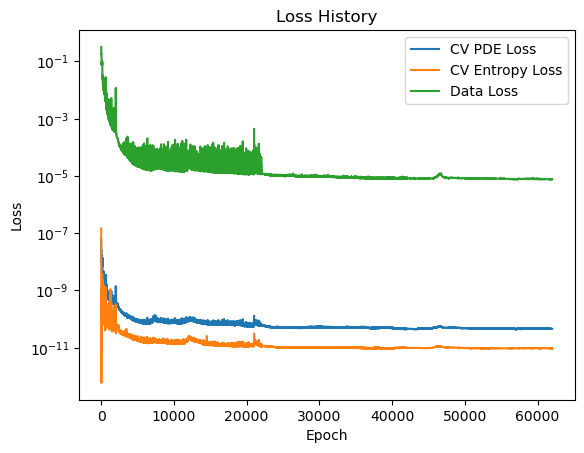

In [6]:
solver.plot_loss_history()

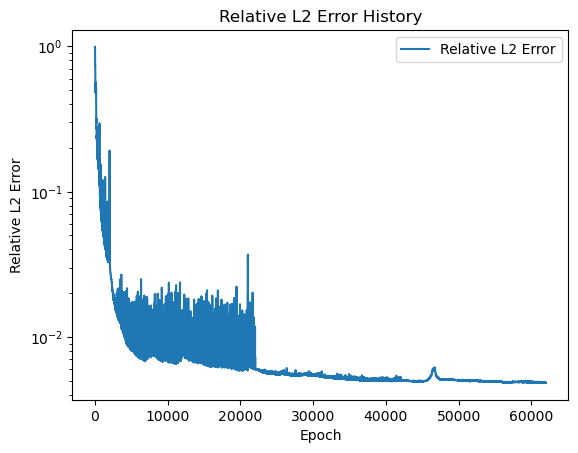

In [7]:
solver.plot_relative_l2_error_history()

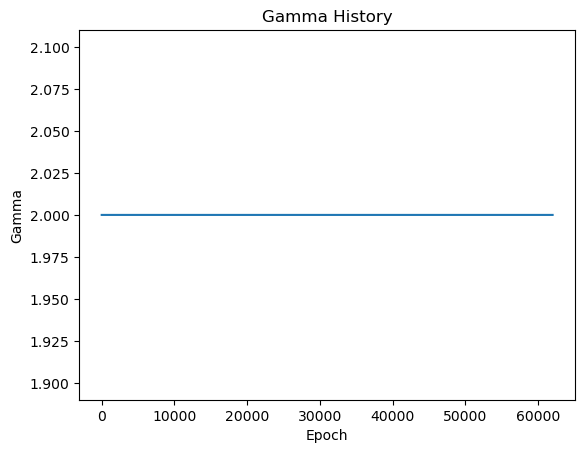

In [8]:
plt.figure()
plt.plot(range(len(gamma_history)), gamma_history)
plt.xlabel("Epoch")
plt.ylabel("Gamma")
plt.title("Gamma History")
plt.show()

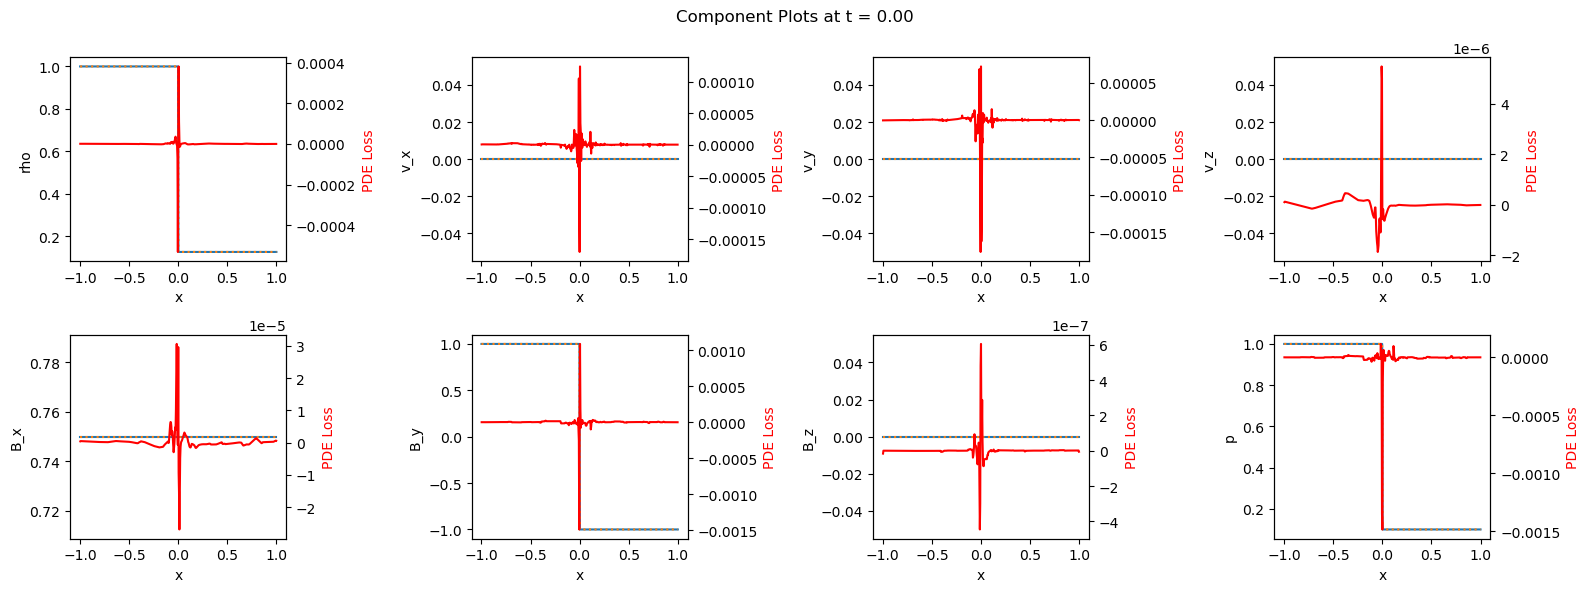

In [9]:
solver.plot_components(
    0,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    loss_to_plot="PDE",
)

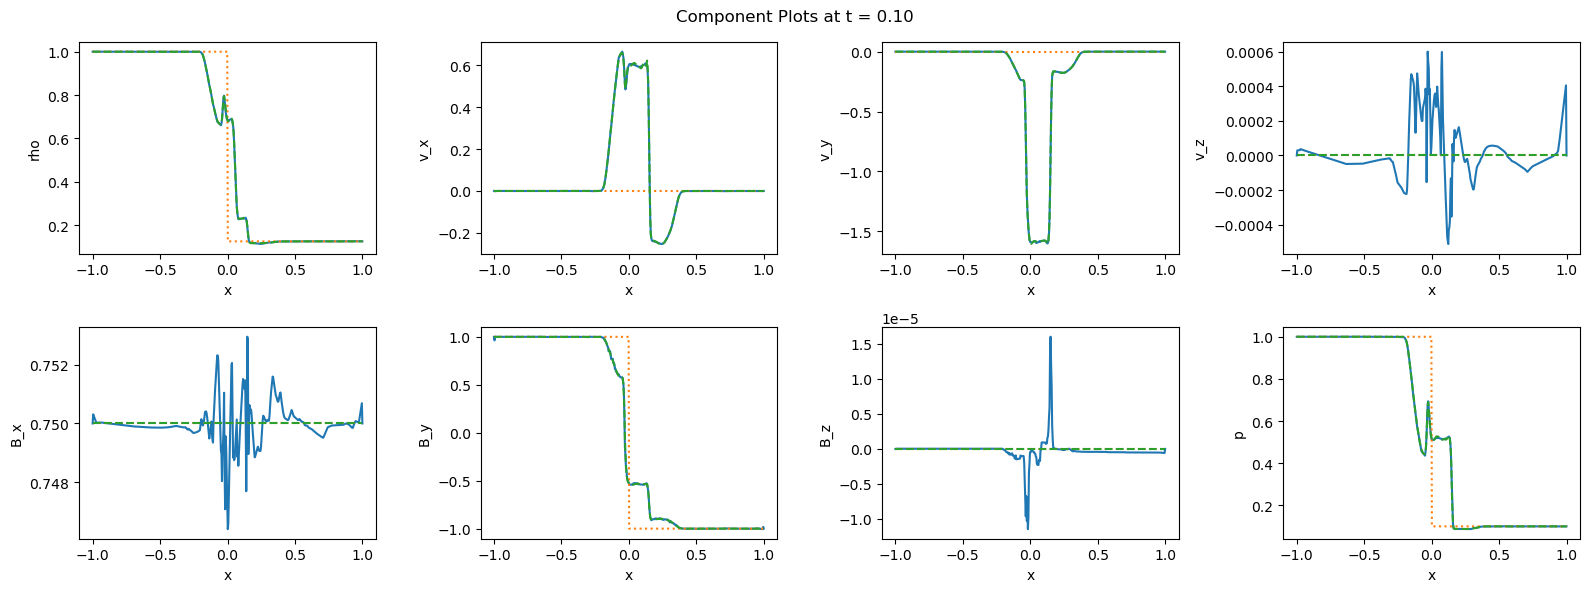

In [10]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    # loss_to_plot="PDE",
)

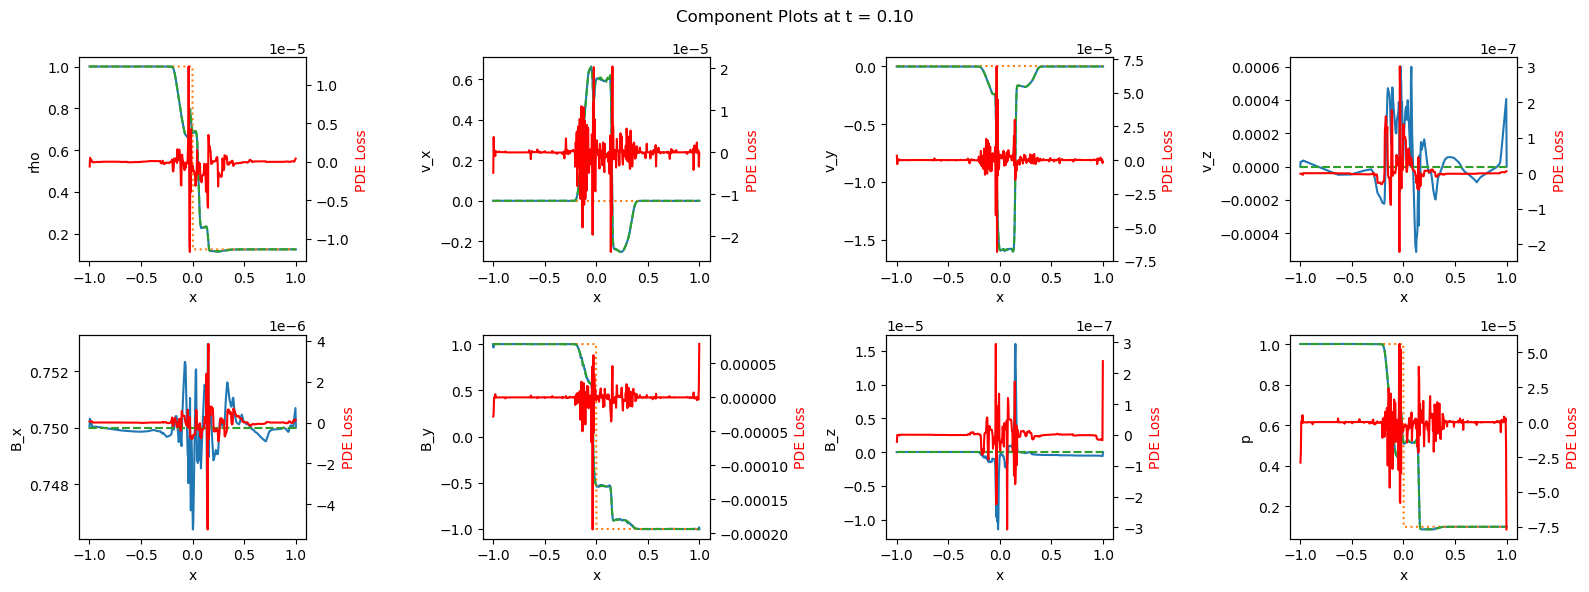

In [11]:
solver.plot_components(
    -1,
    num_rows=2,
    num_cols=4,
    centered=False,
    with_ics=True,
    with_analytic_soln=True,
    loss_to_plot="PDE",
)

In [12]:
# solver.animate_components(
#     "brio_and_wu.gif",
#     num_rows=2,
#     num_cols=4,
#     with_ics=True,
#     with_analytic_soln=True,
# )